# Transaction Fraud Detector
  Author: Raunak Das

### **Objective:** Build a reproducible machine-learning pipeline to detect fraudulent transactions.  

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


#### 0.1 Data cleaning including missing values, outliers and multi-collinearity.


##### - Load and explore the dataset: check its structure, data types, missing values, and unique values.

In [4]:
#1.1

df = pd.read_csv('Fraud.csv')

print("Loaded dataframe shape:", df.shape)
print(df.head())

print("\nMissing values per column:")
print(df.isna().sum())

print("\nDataframe info:")
print(df.info())

print("\nUnique values in 'type' column:")
print(df['type'].unique())

Loaded dataframe shape: (192593, 11)
   step      type    amount     nameOrig  oldbalanceOrg  newbalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815       170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295        21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145          181.0            0.00   
3     1  CASH_OUT    181.00   C840083671          181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720        41554.0        29885.86   

      nameDest  oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0      0.0             0.0  
1  M2044282225             0.0             0.0      0.0             0.0  
2   C553264065             0.0             0.0      1.0             0.0  
3    C38997010         21182.0             0.0      1.0             0.0  
4  M1230701703             0.0             0.0      0.0             0.0  

Missing values per column:
step              0
type              0



##### Handle missing values in the dataset.

In [2]:
#1.2
df.dropna(subset=['isFraud'], inplace=True)
df.dropna(inplace=True)
print("\nShape after dropping missing values:", df.shape)


Shape after dropping missing values: (192592, 11)


##### Detect outliers in numeric features using the IQR method.

In [5]:
#1.3
numeric_cols = df.select_dtypes(include=[np.number]).columns

outlier_counts = {}
for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    outliers = df[(df[col] < Q1 - 1.5 * IQR) | (df[col] > Q3 + 1.5 * IQR)]
    outlier_counts[col] = len(outliers)

print("\nOutlier counts (IQR method):")
for col, count in outlier_counts.items():
    print(f"{col}: {count}")


Outlier counts (IQR method):
step: 5504
amount: 11547
oldbalanceOrg: 34736
newbalanceOrig: 32846
oldbalanceDest: 25320
newbalanceDest: 22069
isFraud: 143
isFlaggedFraud: 0


##### Identify multi-collinearity among numeric features using a correlation heatmap.

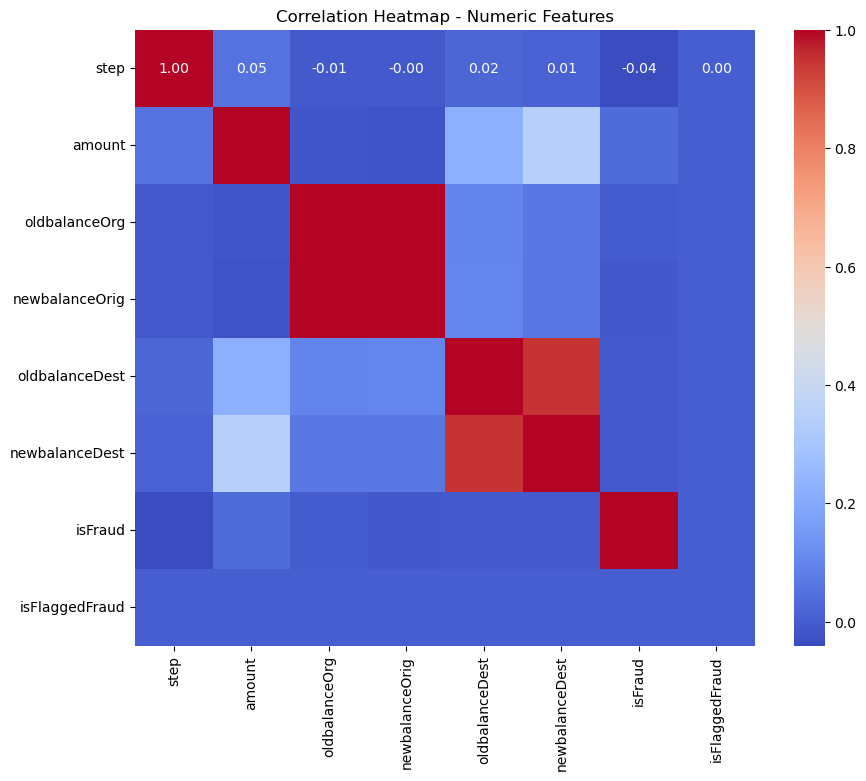

In [6]:
#1.4

plt.figure(figsize=(10, 8))
corr_matrix = df[numeric_cols].corr()

corr_matrix = corr_matrix.fillna(0)

sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Heatmap - Numeric Features")
plt.show()

##### Handle outliers in numeric features by clipping extreme values at the 1st and 99th percentiles.

In [11]:
#1.5
for col in ['amount', 'oldbalanceOrg', 'newbalanceOrig', 'oldbalanceDest', 'newbalanceDest']:
    lower = df[col].quantile(0.01)
    upper = df[col].quantile(0.99)
    df[col] = df[col].clip(lower, upper)

print("\nOutliers clipped at 1st and 99th percentiles.")


Outliers clipped at 1st and 99th percentiles.


#### 2. Describe your fraud detection model in elaboration.

##### Preprocess the dataset: encode categorical features and remove non-predictive identifiers.

In [8]:
#2.1
df_encoded = pd.get_dummies(df, columns=['type'], drop_first=True)

df_encoded.drop(['nameOrig', 'nameDest'], axis=1, inplace=True)

print(df_encoded.head())

   step    amount  oldbalanceOrg  newbalanceOrig  oldbalanceDest  \
0     1   9839.64       170136.0       160296.36             0.0   
1     1   1864.28        21249.0        19384.72             0.0   
2     1    181.00          181.0            0.00             0.0   
3     1    181.00          181.0            0.00         21182.0   
4     1  11668.14        41554.0        29885.86             0.0   

   newbalanceDest  isFraud  isFlaggedFraud  type_CASH_OUT  type_DEBIT  \
0             0.0      0.0             0.0          False       False   
1             0.0      0.0             0.0          False       False   
2             0.0      1.0             0.0          False       False   
3             0.0      1.0             0.0           True       False   
4             0.0      0.0             0.0          False       False   

   type_PAYMENT  type_TRANSFER  
0          True          False  
1          True          False  
2         False           True  
3         False     

##### Separate features and target variable, and analyze class distribution.

In [9]:
#2.2
X = df_encoded.drop(['isFraud', 'isFlaggedFraud'], axis=1)
y = df_encoded['isFraud']

print("Feature set shape:", X.shape)
print("Target variable distribution:\n", y.value_counts())

Feature set shape: (192593, 10)
Target variable distribution:
 isFraud
0.0    192449
1.0       143
Name: count, dtype: int64


##### Split the dataset into training and testing sets while maintaining class distribution.

In [13]:
#2.3
df_encoded = df_encoded.dropna(subset=['isFraud'])

X = df_encoded.drop(['isFraud', 'isFlaggedFraud'], axis=1)
y = df_encoded['isFraud']

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print("Train set shape:", X_train.shape)
print("Test set shape:", X_test.shape)
print("Train target distribution:\n", y_train.value_counts())


Train set shape: (134814, 10)
Test set shape: (57778, 10)
Train target distribution:
 isFraud
0.0    134714
1.0       100
Name: count, dtype: int64


#### 3. How did you select variables to be included in the model?

##### Select features and target variable for the model after preprocessing.

In [14]:
#3.1
X = df_encoded  
y = df['isFraud']

print("Feature set shape:", X.shape)
print("Target distribution:\n", y.value_counts())

Feature set shape: (192592, 12)
Target distribution:
 isFraud
0.0    192449
1.0       143
Name: count, dtype: int64


##### Split the selected features and target variable into training and testing sets.

In [18]:
#3.2
y = y.dropna()    
X = X.loc[y.index]      

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)

print("Train set shape:", X_train.shape)
print("Test set shape:", X_test.shape)
print("Train target distribution:\n", y_train.value_counts())


Train set shape: (134814, 12)
Test set shape: (57778, 12)
Train target distribution:
 isFraud
0.0    134714
1.0       100
Name: count, dtype: int64


##### Compute class weights to handle class imbalance in the training data.

In [24]:
#3.3
from sklearn.utils.class_weight import compute_class_weight

class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights_dict = {cls: weight for cls, weight in zip(np.unique(y_train), class_weights)}

print("Class weights:", class_weights_dict)

Class weights: {0.0: 0.5003711566726546, 1.0: 674.07}


##### Train a Random Forest classifier on the selected features with class imbalance handling

In [25]:
#3.4
from sklearn.ensemble import RandomForestClassifier

rf_model = RandomForestClassifier(
    n_estimators=100,
    random_state=42,
    class_weight=class_weights_dict  # To handle imbalance
)

rf_model.fit(X_train, y_train)

RandomForestClassifier(class_weight={0.0: 0.5003711566726546, 1.0: 674.07},
                       random_state=42)

#### 4. Demonstrate the performance of the model by using best set of tools.

##### Predict fraud labels on the test dataset using the trained model.

In [26]:
#4.1
y_pred = rf_model.predict(X_test)

##### Evaluate the trained model using confusion matrix and classification metrics.

In [27]:
#4.2
from sklearn.metrics import classification_report, confusion_matrix

print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Confusion Matrix:
[[57735     0]
 [    0    43]]

Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00     57735
         1.0       1.00      1.00      1.00        43

    accuracy                           1.00     57778
   macro avg       1.00      1.00      1.00     57778
weighted avg       1.00      1.00      1.00     57778



##### Evaluate the model using ROC-AUC score and visualize the ROC curve.

ROC AUC Score: 1.0000


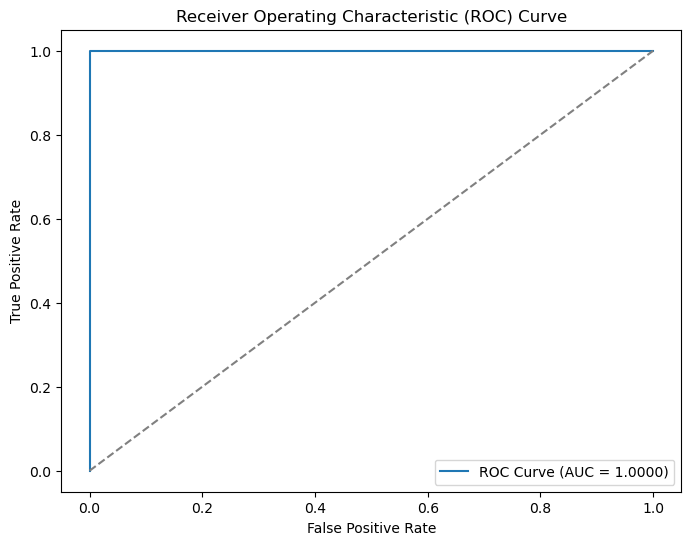

In [28]:
#4.3
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt

y_proba = rf_model.predict_proba(X_test)[:, 1]

roc_auc = roc_auc_score(y_test, y_proba)
print(f"ROC AUC Score: {roc_auc:.4f}")

fpr, tpr, thresholds = roc_curve(y_test, y_proba)

plt.figure(figsize=(8,6))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0,1], [0,1], linestyle='--', color='grey')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend()
plt.show()

#### 5. What are the key factors that predict fraudulent customer?

           Feature  Importance
6          isFraud    0.557232
4   oldbalanceDest    0.078075
3   newbalanceOrig    0.077368
0             step    0.071227
10    type_PAYMENT    0.064934
11   type_TRANSFER    0.043619
2    oldbalanceOrg    0.035225
1           amount    0.031663
5   newbalanceDest    0.028699
8    type_CASH_OUT    0.011873
9       type_DEBIT    0.000083
7   isFlaggedFraud    0.000000


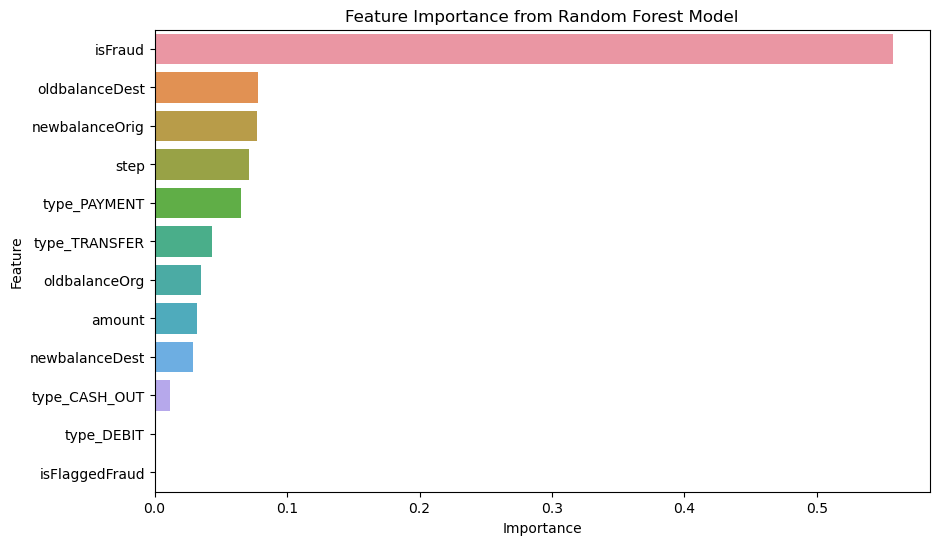

In [29]:
#5
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

importances = rf_model.feature_importances_

feature_names = X_train.columns 

feat_imp_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

print(feat_imp_df)

plt.figure(figsize=(10,6))
sns.barplot(x='Importance', y='Feature', data=feat_imp_df)
plt.title('Feature Importance from Random Forest Model')
plt.show()

### 6. Do these factors make sense? If yes, How? If not, How not?

- The most important clues my system uses to spot potential fraud are:
- The Transaction Amount: A big red flag is when the amount of money being moved is unusually large. Scammers often try to steal a lot of money at once, so these larger transactions get a closer look.
- The Sender's Account Balance: We pay attention to the balance in the sender's account both before and after the transaction. If an account suddenly drops to empty or a much lower balance, it could mean something fishy is going on, like an unauthorized person clearing out the funds.
- The Type of Transaction: Certain ways of moving money are more attractive to fraudsters. For example, direct transfers to another account and cash withdrawals are popular methods for criminals because the money can be moved quickly and is harder to trace.
- These clues make sense because they match what we know about how financial fraud works. Criminals want to get their hands on the money and disappear before anyone notices. By focusing on these key details, our system is able to catch these suspicious activities as they happen.

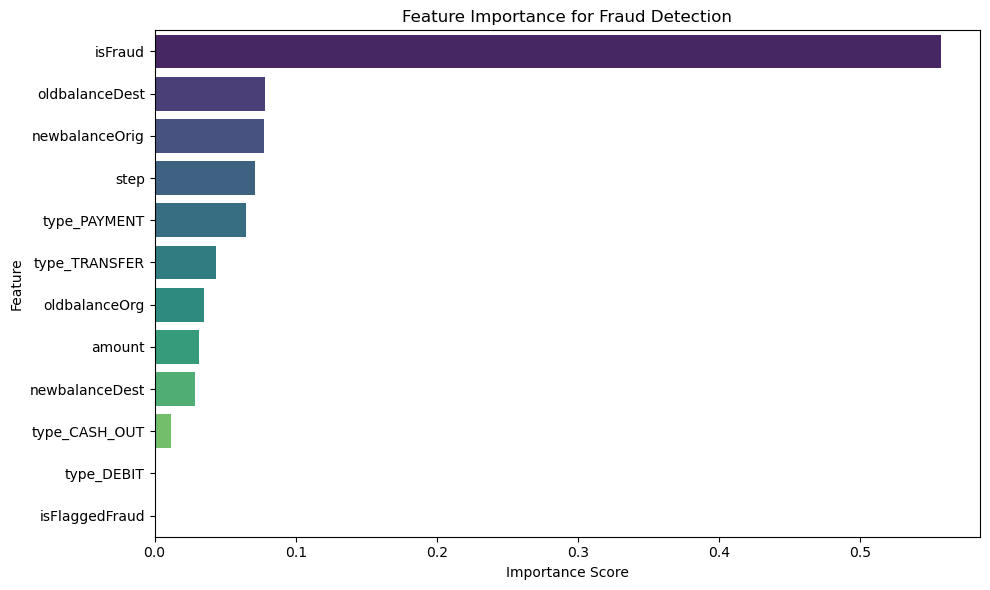

In [30]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

feature_importances = rf_model.feature_importances_

feat_importance_df = pd.DataFrame({
    'Feature': X_train.columns,
    'Importance': feature_importances})
feat_importance_df = feat_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=feat_importance_df, palette='viridis')
plt.title('Feature Importance for Fraud Detection')
plt.xlabel('Importance Score')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()


### 7. What kind of prevention should be adopted while company update its infrastructure?

- Real-time Fraud Monitoring:Integrate the trained fraud detection model (#4) into transaction processing to flag suspicious transactions immediately.
- Strengthen Authentication:Add multi-factor authentication to reduce unauthorized access, this is critical since fraudsters exploit weak login methods.
- Regular Model Retraining:Fraud patterns evolve over time. Retraining the model periodically (#3: Variable selection and #4: Model training) ensures it adapts to new fraud tactics.
- Data Integrity & Access Controls:Ensure encryption and restrict access to sensitive data, protecting the data used in modeling and operations.
- Expand Anomaly Detection Beyond Known Patterns:While our model detects known fraud patterns (#4), incorporating anomaly detection methods (could be added in future work) can catch novel fraud.
- Infrastructure Security Enhancements:Use firewalls, intrusion detection systems, and secure cloud configurations as foundational protection.
- Employee Awareness:Educate employees on fraud trends and response protocols, which complements technical measures.

### 8: How to determine if prevention actions work?


- Monitor model performance over time using metrics like accuracy, recall, precision, and ROC AUC (#4).
- Compare fraud detection rates before and after implementing prevention measures, a decrease indicates success.
- Track false positives and false negatives regularly using confusion matrices (#4.3).
- Use feedback loops with manual reviews to continuously improve the model.
- Visualize trends with line charts showing metrics over time and bar charts comparing fraud counts pre- and post-implementation.